## Additional Resource

https://www.kaggle.com/code/neomatrix369/everything-you-can-do-with-a-time-series-stocks

In [1]:
import pandas as pd
import numpy as np

import sklearn as sk

import xgboost as xgb

import transformers

import torch 

import yfinance as yf

import matplotlib.pyplot as plt

In [66]:
tqqq = yf.Ticker("TQQQ")

stock = tqqq.history(period="1y", interval="1h").reset_index()

stock['MA'] = (stock['Open'] + stock['Close'] ) /2
stock['ratio'] = stock['Close'] / stock['Open']

In [3]:
date = stock['index'].apply(lambda x: str(x)[:10])
month = date.apply(lambda x: int(x[5:7]))

# maybe try the pecentage of month, ie. 21 day of 31 days in a month
day = date.apply(lambda x: int(x[-2:]))


In [4]:
stock['date']= pd.to_datetime(date)
stock['month'] = month
stock['day'] = day
stock['hour']=stock['index'].apply(lambda x: int(str(x)[5:7]))
print(stock.shape)
stock

(1769, 14)


,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,ratio,date,month,day,hour
0,2021-04-22 09:30:00-04:00,54.334999,54.529999,53.779999,54.432499,8542341,0,0.0,54.383749,1.001794,2021-04-22,4,22,4
1,2021-04-22 10:30:00-04:00,54.445000,54.814999,54.330002,54.364300,4437029,0,0.0,54.404650,0.998518,2021-04-22,4,22,4
2,2021-04-22 11:30:00-04:00,54.364948,54.630001,54.205051,54.605000,3123502,0,0.0,54.484974,1.004416,2021-04-22,4,22,4
3,2021-04-22 12:30:00-04:00,54.605000,54.799999,52.919998,53.725250,9909294,0,0.0,54.165125,0.983889,2021-04-22,4,22,4
4,2021-04-22 13:30:00-04:00,53.730000,53.744999,51.970001,52.860249,8851029,0,0.0,53.295124,0.983813,2021-04-22,4,22,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,2022-04-21 12:30:00-04:00,47.240002,47.590000,46.400002,47.240799,16248356,0,0.0,47.240400,1.000017,2022-04-21,4,21,4
1765,2022-04-21 13:30:00-04:00,47.250000,47.380001,45.669998,45.899502,17935581,0,0.0,46.574751,0.971418,2022-04-21,4,21,4
1766,2022-04-21 14:30:00-04:00,45.889999,46.380001,44.880001,45.450001,17968429,0,0.0,45.670000,0.990412,2022-04-21,4,21,4
1767,2022-04-21 15:30:00-04:00,45.450001,45.488201,44.590000,44.990002,14299310,0,0.0,45.220001,0.989879,2022-04-21,4,21,4


(array([18748., 18809., 18871., 18932., 18993., 19052., 19113.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

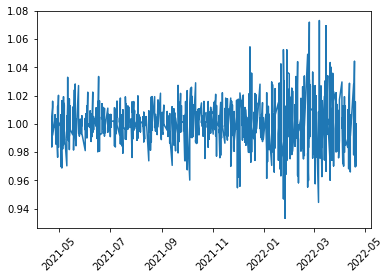

In [5]:
plt.plot(stock['date'], stock['ratio'])
plt.xticks(rotation=45)

In [70]:
stock.High

0       54.529999
1       54.814999
2       54.630001
3       54.799999
4       53.744999
          ...    
1764    47.590000
1765    47.380001
1766    46.380001
1767    45.488201
1768    45.090000
Name: High, Length: 1769, dtype: float64

In [69]:
stock.High.div(stock.High.shift())

0            NaN
1       1.005226
2       0.996625
3       1.003112
4       0.980748
          ...   
1764    0.977167
1765    0.995587
1766    0.978894
1767    0.980772
1768    0.991246
Name: High, Length: 1769, dtype: float64

In [59]:
stock['MA'].head(5)

0    54.383749
1    54.404650
2    54.484974
3    54.165125
4    53.295124
Name: MA, dtype: float64

In [58]:
stock['MA'].shift(3)

0             NaN
1             NaN
2             NaN
3       54.383749
4       54.404650
          ...    
1764    49.750000
1765    49.155001
1766    47.960751
1767    47.240400
1768    46.574751
Name: MA, Length: 1769, dtype: float64

# Predictors

- each row has the previous date or time's
    - price 
    - day's cummulative percentage increase / decrease
    
- trading volume
- month
    - month number
    - percentage month that has passed
- day
- hour


# Target

Either percentage change or price

In [29]:
data = stock.copy()
train = data[data['date'] < '2022-03-10']
test = data[data['date'] >= '2022-03-10']

predictors = ["Volume","month","day","hour","season"]
target = "MA"

x_train, y_train = train[predictors], train[target]
x_test, y_test = test[predictors], test[target]

KeyError: "['season'] not in index"

In [120]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='rmse')

[0]	validation_0-rmse:65.44875	validation_1-rmse:51.22579
[1]	validation_0-rmse:64.79961	validation_1-rmse:50.71069
[2]	validation_0-rmse:64.15695	validation_1-rmse:50.20079
[3]	validation_0-rmse:63.52073	validation_1-rmse:49.69605
[4]	validation_0-rmse:62.89088	validation_1-rmse:49.19641
[5]	validation_0-rmse:62.26732	validation_1-rmse:48.70183
[6]	validation_0-rmse:61.65001	validation_1-rmse:48.21225
[7]	validation_0-rmse:61.03888	validation_1-rmse:47.72763
[8]	validation_0-rmse:60.43386	validation_1-rmse:47.24792
[9]	validation_0-rmse:59.83490	validation_1-rmse:46.77306
[10]	validation_0-rmse:59.24194	validation_1-rmse:46.30301
[11]	validation_0-rmse:58.65491	validation_1-rmse:45.83773
[12]	validation_0-rmse:58.07376	validation_1-rmse:45.37716
[13]	validation_0-rmse:57.49844	validation_1-rmse:44.92127
[14]	validation_0-rmse:56.92887	validation_1-rmse:44.46999
[15]	validation_0-rmse:56.36501	validation_1-rmse:44.02330
[16]	validation_0-rmse:55.80680	validation_1-rmse:43.58114


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:55.25419	validation_1-rmse:43.14348
[18]	validation_0-rmse:54.70711	validation_1-rmse:42.71026
[19]	validation_0-rmse:54.16551	validation_1-rmse:42.28143
[20]	validation_0-rmse:53.62934	validation_1-rmse:41.85697
[21]	validation_0-rmse:53.09855	validation_1-rmse:41.43683
[22]	validation_0-rmse:52.57307	validation_1-rmse:41.02095
[23]	validation_0-rmse:52.05286	validation_1-rmse:40.60931
[24]	validation_0-rmse:51.53786	validation_1-rmse:40.20187
[25]	validation_0-rmse:51.02803	validation_1-rmse:39.79857
[26]	validation_0-rmse:50.52331	validation_1-rmse:39.39938
[27]	validation_0-rmse:50.02365	validation_1-rmse:39.00426
[28]	validation_0-rmse:49.52900	validation_1-rmse:38.61316
[29]	validation_0-rmse:49.03932	validation_1-rmse:38.22606
[30]	validation_0-rmse:48.55454	validation_1-rmse:37.84291
[31]	validation_0-rmse:48.07463	validation_1-rmse:37.46367
[32]	validation_0-rmse:47.59953	validation_1-rmse:37.08831
[33]	validation_0-rmse:47.12920	validation_1-rmse:36.716

[155]	validation_0-rmse:14.22146	validation_1-rmse:12.82245
[156]	validation_0-rmse:14.08411	validation_1-rmse:12.73186
[157]	validation_0-rmse:13.94833	validation_1-rmse:12.64567
[158]	validation_0-rmse:13.81386	validation_1-rmse:12.54846
[159]	validation_0-rmse:13.68026	validation_1-rmse:12.45772
[160]	validation_0-rmse:13.54846	validation_1-rmse:12.37088
[161]	validation_0-rmse:13.41801	validation_1-rmse:12.28768
[162]	validation_0-rmse:13.28882	validation_1-rmse:12.19471
[163]	validation_0-rmse:13.16050	validation_1-rmse:12.10878
[164]	validation_0-rmse:13.03392	validation_1-rmse:12.02575
[165]	validation_0-rmse:12.90854	validation_1-rmse:11.94717
[166]	validation_0-rmse:12.78441	validation_1-rmse:11.85826
[167]	validation_0-rmse:12.66112	validation_1-rmse:11.77501
[168]	validation_0-rmse:12.53941	validation_1-rmse:11.69913
[169]	validation_0-rmse:12.41896	validation_1-rmse:11.61317
[170]	validation_0-rmse:12.29943	validation_1-rmse:11.53260
[171]	validation_0-rmse:12.18106	validat

[295]	validation_0-rmse:3.84934	validation_1-rmse:6.44969
[296]	validation_0-rmse:3.81608	validation_1-rmse:6.42850
[297]	validation_0-rmse:3.78315	validation_1-rmse:6.41102
[298]	validation_0-rmse:3.75087	validation_1-rmse:6.39319
[299]	validation_0-rmse:3.71837	validation_1-rmse:6.37148
[300]	validation_0-rmse:3.68656	validation_1-rmse:6.35452
[301]	validation_0-rmse:3.65450	validation_1-rmse:6.33285
[302]	validation_0-rmse:3.62343	validation_1-rmse:6.31660
[303]	validation_0-rmse:3.59276	validation_1-rmse:6.30054
[304]	validation_0-rmse:3.56207	validation_1-rmse:6.28436
[305]	validation_0-rmse:3.53148	validation_1-rmse:6.26355
[306]	validation_0-rmse:3.50180	validation_1-rmse:6.24804
[307]	validation_0-rmse:3.47218	validation_1-rmse:6.23398
[308]	validation_0-rmse:3.44274	validation_1-rmse:6.21380
[309]	validation_0-rmse:3.41368	validation_1-rmse:6.19641
[310]	validation_0-rmse:3.38490	validation_1-rmse:6.18382
[311]	validation_0-rmse:3.35656	validation_1-rmse:6.16932
[312]	validati

[437]	validation_0-rmse:1.40778	validation_1-rmse:4.99985
[438]	validation_0-rmse:1.40086	validation_1-rmse:4.99670
[439]	validation_0-rmse:1.39424	validation_1-rmse:4.99184
[440]	validation_0-rmse:1.38719	validation_1-rmse:4.98870
[441]	validation_0-rmse:1.38030	validation_1-rmse:4.98559
[442]	validation_0-rmse:1.37346	validation_1-rmse:4.98318
[443]	validation_0-rmse:1.36674	validation_1-rmse:4.98019
[444]	validation_0-rmse:1.36031	validation_1-rmse:4.97585
[445]	validation_0-rmse:1.35416	validation_1-rmse:4.97120
[446]	validation_0-rmse:1.34818	validation_1-rmse:4.96616
[447]	validation_0-rmse:1.34216	validation_1-rmse:4.96167
[448]	validation_0-rmse:1.33581	validation_1-rmse:4.95902
[449]	validation_0-rmse:1.32999	validation_1-rmse:4.95333
[450]	validation_0-rmse:1.32399	validation_1-rmse:4.95074
[451]	validation_0-rmse:1.31809	validation_1-rmse:4.94846
[452]	validation_0-rmse:1.31225	validation_1-rmse:4.94593
[453]	validation_0-rmse:1.30649	validation_1-rmse:4.94343
[454]	validati

[579]	validation_0-rmse:0.91374	validation_1-rmse:4.67164
[580]	validation_0-rmse:0.91222	validation_1-rmse:4.67001
[581]	validation_0-rmse:0.91020	validation_1-rmse:4.66824
[582]	validation_0-rmse:0.90854	validation_1-rmse:4.66661
[583]	validation_0-rmse:0.90656	validation_1-rmse:4.66477
[584]	validation_0-rmse:0.90461	validation_1-rmse:4.66294
[585]	validation_0-rmse:0.90317	validation_1-rmse:4.66159
[586]	validation_0-rmse:0.90199	validation_1-rmse:4.66081
[587]	validation_0-rmse:0.90003	validation_1-rmse:4.65878
[588]	validation_0-rmse:0.89888	validation_1-rmse:4.65802
[589]	validation_0-rmse:0.89694	validation_1-rmse:4.65627
[590]	validation_0-rmse:0.89582	validation_1-rmse:4.65554
[591]	validation_0-rmse:0.89391	validation_1-rmse:4.65381
[592]	validation_0-rmse:0.89282	validation_1-rmse:4.65309
[593]	validation_0-rmse:0.89095	validation_1-rmse:4.65139
[594]	validation_0-rmse:0.88983	validation_1-rmse:4.65064
[595]	validation_0-rmse:0.88875	validation_1-rmse:4.64957
[596]	validati

[721]	validation_0-rmse:0.77067	validation_1-rmse:4.55291
[722]	validation_0-rmse:0.77028	validation_1-rmse:4.55262
[723]	validation_0-rmse:0.76946	validation_1-rmse:4.55266
[724]	validation_0-rmse:0.76893	validation_1-rmse:4.55244
[725]	validation_0-rmse:0.76813	validation_1-rmse:4.55247
[726]	validation_0-rmse:0.76776	validation_1-rmse:4.55226
[727]	validation_0-rmse:0.76709	validation_1-rmse:4.55272
[728]	validation_0-rmse:0.76650	validation_1-rmse:4.55222
[729]	validation_0-rmse:0.76587	validation_1-rmse:4.55225
[730]	validation_0-rmse:0.76489	validation_1-rmse:4.55150
[731]	validation_0-rmse:0.76439	validation_1-rmse:4.55159
[732]	validation_0-rmse:0.76343	validation_1-rmse:4.55085
[733]	validation_0-rmse:0.76292	validation_1-rmse:4.55072
[734]	validation_0-rmse:0.76255	validation_1-rmse:4.55052
[735]	validation_0-rmse:0.76193	validation_1-rmse:4.55006
[736]	validation_0-rmse:0.76097	validation_1-rmse:4.54926
[737]	validation_0-rmse:0.76049	validation_1-rmse:4.54941
[738]	validati

[863]	validation_0-rmse:0.69036	validation_1-rmse:4.50845
[864]	validation_0-rmse:0.68972	validation_1-rmse:4.50667
[865]	validation_0-rmse:0.68910	validation_1-rmse:4.50630
[866]	validation_0-rmse:0.68891	validation_1-rmse:4.50612
[867]	validation_0-rmse:0.68833	validation_1-rmse:4.50598
[868]	validation_0-rmse:0.68797	validation_1-rmse:4.50591
[869]	validation_0-rmse:0.68750	validation_1-rmse:4.50556
[870]	validation_0-rmse:0.68731	validation_1-rmse:4.50542
[871]	validation_0-rmse:0.68705	validation_1-rmse:4.50544
[872]	validation_0-rmse:0.68654	validation_1-rmse:4.50518
[873]	validation_0-rmse:0.68619	validation_1-rmse:4.50508
[874]	validation_0-rmse:0.68554	validation_1-rmse:4.50486
[875]	validation_0-rmse:0.68507	validation_1-rmse:4.50470
[876]	validation_0-rmse:0.68474	validation_1-rmse:4.50461
[877]	validation_0-rmse:0.68437	validation_1-rmse:4.50463
[878]	validation_0-rmse:0.68366	validation_1-rmse:4.50430
[879]	validation_0-rmse:0.68296	validation_1-rmse:4.50402
[880]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [121]:
y_pred = reg.predict(x_test)

(array([19059., 19066., 19073., 19083., 19090., 19097., 19104.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

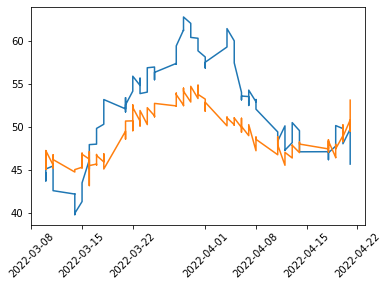

In [122]:
plt.plot(test['date'], test['MA'])
plt.plot(test['date'], y_pred)
plt.xticks(rotation=45)

In [123]:
sk.metrics.mean_absolute_error(y_test,y_pred)

3.7454093403793407

In [124]:
sk.metrics.mean_squared_error(y_test,y_pred, squared=False)

4.4727834949005505

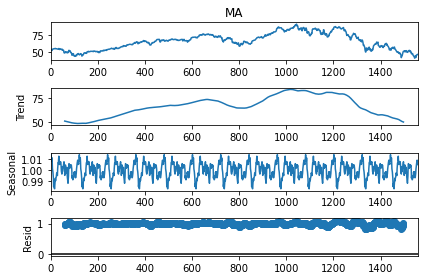

In [36]:

from random import randrange
from pandas import Series
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(y_train, model='multiplicative', period=120)
result.plot()
plt.show()

In [32]:
season = result.seasonal
data['season'] = season

In [38]:
result.trend

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1553   NaN
1554   NaN
1555   NaN
1556   NaN
1557   NaN
Name: trend, Length: 1558, dtype: float64

In [26]:
ratio = data['ratio']

In [27]:
[ratio[i]-season[i] for i in range(len(season))]

[0.013612940434778564,
 0.007888181299849584,
 0.011494592067945897,
 -0.011093526289930766,
 -0.012032855548372412,
 -0.008372867048208499,
 0.007645411543460989,
 0.01425403245307133,
 0.020040986479964773,
 0.008422645890714953,
 0.004330502528965052,
 -0.0022887173596510824,
 -0.0008899492059153413,
 -0.015744122950061668,
 -0.0014171535402078828,
 0.0002528644246975187,
 -0.009071695616876041,
 -0.0073707951944890215,
 -0.003502678821116767,
 -0.013717771454470173,
 -0.009110655112934518,
 -0.027798602305193598,
 -0.01555678644168712,
 -0.011220333173039387,
 -0.016979622607559586,
 -0.009177154364016005,
 -0.011988098745127851,
 -0.011560942276323538,
 -0.002099866247156079,
 -0.009434002199404934,
 -0.002280293983152104,
 0.0010785004186051328,
 -0.000629281611351451,
 0.010493074181005313,
 -0.00011952894356948018,
 -0.01678780039514649,
 0.0066156686507159446,
 -0.005279634040075254,
 0.02151214113099731,
 0.014511656607680501,
 0.003754482977211926,
 0.003155480824896695,
 0.